### Imports

For the most of this code breakfast you need the following libraries installed:

- numpy
- pandas
- matplotlib
- sklearn

If you are new to Python, we recommend using [Anaconda](https://www.anaconda.com) as it already comes with most essential libraries installed.

In [1]:
#main imports
import numpy as np
import pandas as pd 
import matplotlib.pylab as plt
from matplotlib import dates

from sklearn.linear_model import LinearRegression

%matplotlib inline 

## Amazing Breakfast Ideas: for staying at home and self-isolation

(click on the pic)

<p></p>

<a href="https://www.the-postillon.com/2020/03/self-isolation-for-foodies-our-top-10.html">
<img src="https://1.bp.blogspot.com/-9BoH6z1zw74/XmEpV37CDKI/AAAAAAAA4IQ/Z10kBR9ktSQTiMoG2V4HmyMnDYJtJ8sSwCLcBGAsYHQ/s1600/Corona-Rezepte.jpg" style="width: 600px;" href/>
 </a>

## Program

During this code breakfast we will learn about:

- What does a time series consist of?
- What is seasonality and why is it important?
- Ways (not) to identify seasonality
- The power of linear models
- Splitting time series for forecasting
- Manual error-trend-seasonality decomposition
- Feature engineering tricks to improve your models
- Feature significance & importance
- Fitting sine curve(s)
- Forecast evaluation
- and more!

**Bonus:** sharing breakfast recipes!

## Data

We will use a dataset containing daily air quality index in Californian counties between 2007 and 2017 based on a larger dataset from [Kaggle](https://www.kaggle.com/epa/carbon-monoxide). Each datapoint indicates the average air quality index on a certain day: the higher - the more polluted.

In [ ]:
air_df = pd.read_csv('data/air_quality.csv', index_col='date_local', parse_dates=True)
air_df.head()

In [ ]:
air_df.plot(figsize=(18,6))
air_df['2010-09':'2012-02'].plot(figsize=(18,6));

We can notice some regularities over these years:

- **Trends** (upward / horizontal / downward)
- **Seasonality** (predictably repeating cycles - weekly/monthly/yearly etc)
- **Cyclical components** (patterns with no set repetition - for example trend breaks or random shocks) 
- **Residuals** (the remaining part of the series that cannot be further explicitly modeled)

## Dealing with Seasonality
Seasonality obscures the actual signal, which complicates both understanding of the underlying processes and further forecasting. Understanding it gets us closer to what actually happens in the data ― which also means easier forecasting. Identifying and dealing with seasonality is also important for a range of other reasons. Here is a summary:

- Getting closer to the actual signal
- Understanding the nature of seasonal spikes and drops
- Identifying plateaus and seasonality magnitude dynamics
- Deseasonalizing data, which is required for some forecasting algorithms
- Letting forecasting models explicitly predict seasonal effects
- Seasonality is very typical for modern day business data

One of the simplest ways to identify signal is to substantially **smooth** our time series. This can average out the effects of seasonality, but can come with its own issues:

In [ ]:
(
    air_df
    .assign(rolling = lambda df: df['aqi'].rolling(365, center=True).mean(),
            #exponential=lambda df: df['aqi'].ewm(alpha=0.001).mean()
           )
    .plot(figsize=(18,6))

);

One can naively suggest that the remaining variation in the series is largely seasonality with a bit of noise, which can be in its turn smoothed out as well:

In [ ]:
(
    air_df
    .assign(rolling = lambda df: df['aqi'].rolling(365, center=True).mean(),
            seasonality = lambda df: df['aqi'] - df['rolling'],
            seasonality_smoothed = lambda df: df['seasonality'].rolling(90, center=True).mean()
           )
    .loc['2009':'2015']
    #[['seasonality','seasonality_smoothed']]
    [['seasonality_smoothed']]
    .plot(figsize=(18,6))

);

#### Is this an adequate representation of seasonal cycles? Does it have any issues?



## Linear Modeling Approach

An alternative way to identify the main pattern(s) taking place in the data is to fit a linear regression. Even the most basic linear model with a single time component can inform us about the general trend, (mostly) leaving the seasonality aside.

In [ ]:
air_df['time'] = np.arange(len(air_df.index))

X = air_df[['time']]
y = air_df['aqi'].values

In [ ]:
#fitting a linear model
lm = LinearRegression()
lm.fit(X, y)

air_df['linear_trend'] = lm.predict(X)

In [ ]:
air_df[['aqi','linear_trend']].plot(figsize=(16,4));

As simple as this is, it gives us an idea of what happens over time. Of course a single linear trend cannot take dynamical changes in growth/decline rates into account. But we can still take care of this by adding break indicators & interaction terms:

In [ ]:
X_break = (
    air_df
    .assign(after2014 = [1 if el>pd.Timestamp('2014-6') else 0 for el in air_df.index],
            interaction = lambda df: df['time']*df['after2014'])
    [['time', 'after2014','interaction']]
)

lm_break = LinearRegression().fit(X_break, y)

air_df['linear_trend_break'] = lm_break.predict(X_break)

In [ ]:
air_df[['aqi','linear_trend_break']].plot(figsize=(16,4));

### Feature Engineering

We may want to do more than just identifying the trend though. Modeling the seasonality would allow us to understand and quantify the seasonal effects. And this means an ability to model not just the average behavior, but exact values during each season.

A simple way to achieve this would be to add seasonal dummy terms to the baseline linear regression. In fact, *feature engineering* can be a very powerful tool in Time Series analysis, allowing us to capture rather complex patters with a few simple engineered variables added.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
#identifying months and preprocessing them
air_df['month']=air_df.index.month

#train-test split
air_df_train = air_df.loc[:'2015-4'].copy()
air_df_test = air_df.loc['2015-5':].copy()

In [ ]:
#train-test split illustrated
fig, ax = plt.subplots(figsize=(18,6))
air_df_train[['aqi']].plot(ax=ax)
air_df_test[['aqi']].plot(ax=ax)
plt.legend(["train set","test set"]);

In [ ]:
#adding month indicators
X_monthly=air_df_train[['time','month']]
y_train = air_df_train['aqi'].values

feature_transformer = ColumnTransformer(
      [('categorical', OneHotEncoder(drop='first'), ['month'])],
    remainder='passthrough'
)

In [ ]:
#training the model
model_monthly = Pipeline([
    ('preprocess', feature_transformer),
    ('model', LinearRegression())
])

lm_monthly = model_monthly.fit(X_monthly, y_train)
print(f"R^2 is {round(lm_monthly.score(X_monthly, y_train),3)}")

air_df['y_pred_monthly'] = lm_monthly.predict(air_df[['time','month']])

*Note:* **R-squared** (coefficient of determination) is a statistical measure of how close the data are to the fitted regression line. It shows the percentage of the dependent variable variation that is explained by our model

In [ ]:
air_df[['aqi','y_pred_monthly']].loc[:'2015-4'].plot(figsize=(16,4), color=['#499DE6','red']);

This simple model appears to reasonably capture the observed seasonality, even if has a number of drawbacks. This model assumes fixed monthly jumps, while the actual seasonality seems more complex than just fixed jumps or drops, but this approach already illustrates the main patterns. Moreover, it already allows us to separate seasonality from the trend and the residuals:

In [ ]:
average_season_effect = np.dot(lm_monthly['model'].coef_[:-1], [1/12]*11)

simple_ets = (
    air_df
    [['aqi','y_pred_monthly', 'time']]
    .loc[:'2015-4']
    .rename(columns={"aqi": "y_real", "y_pred_monthly": "y_hat"})
    .assign(residuals = lambda df: df['y_real']-df['y_hat'],
            trend = lambda df: lm_monthly['model'].intercept_+lm_monthly['model'].coef_[-1]*df['time']+average_season_effect,
            seasonal = lambda df: df['y_hat']-df['trend']
           )
)

In [ ]:
simple_ets[['y_real','y_hat','trend']].plot(figsize=(16,4))
simple_ets[['seasonal']].plot(figsize=(16,2), c='m')
simple_ets[['residuals']].plot(figsize=(16,2), c='r');

Having broken down a time series into its major components, we can now also *detrend* or *deseasonalize* it by subtracting the respective components. This can provide us with a clearer picture of what is going on over time aside from the trend and/or the seasonal fluctuations.

In [ ]:
simple_ets = (simple_ets
              .assign(deseasonalized = lambda df: df['y_real']-df['seasonal'],
                      detrended = lambda df: df['y_real']-df['trend']))

simple_ets[['deseasonalized']].plot(figsize=(16,3), c='g', label="deseasonalized time series")
simple_ets[['detrended']].plot(figsize=(16,3), c='m', label="detrended time series");

### Gradual Seasonal Filtering

Often seasonal effects do not come just as fixed spikes or drops. They may have gradually increasing and decreasing effects as their peak approaches and moves away in time. In such cases we may want to use a neater alternative to seasonal dummies - *gradual seasonal filters*.

There are a variety of such features that we could create. A simple yet effective example are linear monthly spikes:

$$ \phi(x_i) = \max( 1 - \frac{| x - x^*|}{n} , 0)$$

where $x$ is a given data point, $x^*$ is the peak of the current filter, and $n$ is the interval of growth/decline of the spike around the peak (e.g. 30 days). In practice, a filter like this translates into a variable with values the closer to 1 (or to 0), the closer (or the further) a particular date is from the given peak.

In [ ]:
def gsf_feature_maker(day, center_day, n=30):
    if day - center_day >= 334:
        day=day-365 #ensures continuity for December-January
    return np.fmax(-np.abs(day - center_day)/n + 1, 0)

base = [gsf_feature_maker(el, 200) for el in np.arange(365)]
plt.figure(figsize = (17,3))
plt.plot(base);

Such gradual filters could be especially handy when dealing with daily (or even hourly) data that typically exhibits more gradual seasonal effects. A separate filter can be assigned to each potential seasonal peak — each month in the example below. But really your creativity is the limit.

In [ ]:
months = pd.date_range('2008-01-01', periods = 12, freq = 'M')

fig, ax = plt.subplots(figsize=(17,3))
for month in months:
    ax.plot([gsf_feature_maker(el, month.dayofyear) for el in np.arange(365)])

In [ ]:
air_df_gsf=air_df[['aqi','time']].copy()
air_df_gsf['month']=air_df_gsf.index.month
air_df_gsf['dayofyear']=air_df_gsf.index.dayofyear

#determining month starting days as day of the year numbers
month_start_days=[]
for i in range(1,13):
    month_start_days.append(air_df_gsf.loc[lambda df: df.month==i].iloc[0]['dayofyear'])
    
month_start_days

In [ ]:
#Adding 12 GSF features to the dataset
for i in range(12):
    feature_name="f"+str(i)
    peak = month_start_days[i]
    air_df_gsf[feature_name] = [gsf_feature_maker(date.dayofyear, peak) for date in air_df_gsf.index]

In [ ]:
air_df_gsf.head()

In [ ]:
#inspecting the new features visually
fig, ax = plt.subplots(figsize=(17,3))
for i in range(12):
    feature_name="f"+str(i)
    air_df_gsf[[feature_name]].loc[:'2008'].plot(ax=ax)

In [ ]:
X_gsf = np.c_[air_df_gsf[['time']], air_df_gsf.iloc[:,4:]]
X_gsf_train = np.c_[air_df_gsf[['time']].loc[:'2015-4'], air_df_gsf.iloc[:,4:].loc[:'2015-4']]
y_train = air_df_gsf['aqi'].loc[:'2015-4']

lm_gsf = LinearRegression().fit(X_gsf_train, y_train)
print(f"R^2 is {round(lm_gsf.score(X_gsf_train, y_train),3)}")

air_df_gsf['gsf_pred'] = lm_gsf.predict(X_gsf)

In [ ]:
air_df_gsf[['aqi','gsf_pred']].loc[:'2015-4'].plot(figsize=(16,4), color=['#499DE6','red']);

## Advanced gradual seasonal filtering

A more elegant alternative to linear spikes: a filter based on Gaussian distribution around the peak:

In [ ]:
def rbf_feature_values(day, center_day, year_days=365, alpha = 0.005):
    return np.exp(-((day - center_day)**2)/2*alpha)

base = [rbf_feature_values(el, 200, alpha = 0.001) for el in np.arange(365)]
plt.figure(figsize = (17,3))
plt.plot(base);

We will however leave this as material for further self-study and self-exploration

## GSF Summary

**Pros** 

- simple feature engineering trick
- all variables are interpretable
- seasonal effects can be quantified
- focus on filtering out the long term season, other fluctuations can be modeled separately

**Cons** 

- the model can get a bit biased 
- the model may have issues if the seasonality changes over time (fixable)

## Feature significance

Another nice possibility that comes with linear seasonality modeling is statistical testing. We can distinguish features that actually help our model from useless ones. Useless features are typically an unnecessary strain on our model. Let's have a look: 

In [ ]:
from regressors import stats

print("\n=========== SUMMARY ===========")
xlabels = ["time"] + list(air_df_gsf.iloc[:,4:-1].columns)
stats.summary(lm_gsf, X_gsf_train, y_train, xlabels)

Looks like almost all features are significant except for f2. In a nutshell: we are checking if *p-values* are smaller than 0.05. Roughly speaking, a *p-value* informs us of how likely it is that we got this particular coefficient even though it should actually be zero. Therefore the lower the p-value - the more confident we are that the respective feature is an important factor in our model.

We could also achieve similar conclusions if we use special types of linear regressions that only select valuable features, such as Ridge / Lasso regressions. Simply put, we can punish our model for including features that don't really improve the fit. This is a good direction for further [reading](http://www.few.vu.nl/~wvanwie/Courses/HighdimensionalDataAnalysis/WNvanWieringen_HDDA_Lecture234_RidgeRegression_20182019.pdf) and self-study!

## Outlier detection

Having a reasonable model for seasonality, we can now also use it to better understand what was happening in the past. Most notably, we can identify periods that stand out from regular seasonal patterns. This brings us to outlier detection. While there are many techniques for that, a simple natural way would be to look for data points deviating from the model more than a certain threshold percentage:

In [ ]:
air_df_gsf['aqi'].iloc[0]

In [ ]:
#detecting datapoints deviating more than 20% from the model
outliers=[]

for i in range(len(air_df_gsf)):
    
    if np.abs(air_df_gsf['aqi'].iloc[i]-air_df_gsf['gsf_pred'].iloc[i])/air_df_gsf['gsf_pred'].iloc[i]>0.15:
        outliers.append(air_df_gsf['aqi'].iloc[i])
    else:
        outliers.append(np.nan)

air_df_gsf['outliers']=outliers

In [ ]:
#illustrating outliers
fig, ax = plt.subplots(figsize=(18,6))
air_df_gsf[['aqi','gsf_pred']].loc[:'2012'].plot(color=['#499DE6','green'], ax=ax, alpha=0.7)
air_df_gsf[['outliers']].loc[:'2012'].plot(color='orangered', ax=ax);

In [ ]:
#2014 zoom in: droughts and wildfires
fig, ax = plt.subplots(figsize=(18,6))
air_df_gsf[['aqi','gsf_pred']].loc['2014'].plot(color=['#499DE6','green'], ax=ax, alpha=0.7)
air_df_gsf[['outliers']].loc['2014'].plot(color='orangered', ax=ax);

Checking against a certain percentage threshold may be a bit arbitrary. That's why more advanced approaches to outlier detection use confidence bounds around the model instead. The example above should nonetheless illustrate the idea of how such techniques work.

## Fitting a Sine curve?

An alternative approach to using dummies or other similar features could be fitting a predetermined function that naturally mimics the behavior of our time series. In fact our data kind of looks like sine fluctuations, doesn't it?

In [ ]:
air_df_train['sine_example']=2*np.sin(0.015*air_df_train['time'])

air_df_train[['aqi', 'sine_example']].plot(figsize=(18,6), color=['#499DE6','red']);

But how can we fit a sine curve? Can we still use linear regression?

Yes!!

A standard linear model fitting a sine curve over a year would have the following form:

$$ y_i = w_0 + w_1 t_i + w_2 \sin{(\frac{2 \pi t_i}{365} + \Phi)} + \varepsilon_i$$

$w_2$ determines the amplitude (gap between top and bottom parts) and $\Phi$ shifts the sine curve left/right along the *x-axis*. The problem though is that we have two parameters for a single linear component. Luckily we can use a very neat trick from Trigonometry that will help us separate the two:

$$ \sin{(a - b)} = \sin{(a)}\cos{(b)} - \cos{(a)}\sin{(b)}$$

Therefore:

$$ \sin{(2 \pi t_i + \Phi)} = \sin{(2 \pi t_i)}\cos{(\Phi)} - \cos{(2 \pi t_i)}\sin{(\Phi)}$$

Since $\sin{(\Phi)}$ and $\cos{(\Phi)}$ are just constants, we can then simply fit the following linear model:

$$ y_i = w_0 + w_1 t_i + w_2 \sin{(\frac{2 \pi t_i}{365})} + w_3 \cos{(\frac{2 \pi t_i}{365})} + \varepsilon_i$$

We simply need to calculate the $\sin$ and $\cos$ components as new variables:

In [ ]:
sin_df = (
    air_df[['aqi','time']]
    .assign(sin = lambda df: np.sin(2*np.pi*df.time/365),
            cos = lambda df: np.cos(2*np.pi*df.time/365),
            #sin_time = lambda df: df.sin*df.time,
            #cos_time = lambda df: df.cos*df.time
        
    )

)

In [ ]:
sin_df.head()

In [ ]:
X_sin = sin_df.iloc[:,1:]
X_sin_train = X_sin.loc[:'2015-4']


In [ ]:
lm_sin = LinearRegression().fit(X_sin_train, y_train)
print(f"R^2 is {round(lm_sin.score(X_sin_train, y_train),3)}")

sin_df['aqi_pred'] = lm_sin.predict(X_sin)

In [ ]:
sin_df[['aqi','aqi_pred']].loc[:'2015-4'].plot(figsize=(18,6), color=['#499DE6','red']);

Looks quite natural, doesn't it? One problem is though that it looks like the fluctuations should shrink over time. *Think about how we can fix this.*

Now we can also perform the error-trend-seasonality decomposition again:

In [ ]:
sin_df['trend'] = lm.intercept_+lm.coef_[0]*np.arange(len(air_df.index))
sin_df['seasonal'] = sin_df['aqi_pred'] - sin_df['trend']
sin_df['resid'] = sin_df['aqi'] - sin_df['aqi_pred']

(
    sin_df[['aqi','aqi_pred','trend', 'seasonal', 'resid']]
    .loc[:'2015-4']
    .plot(figsize=(18,6), legend=False, color=['#499DE6','red', 'green', 'orangered', 'slategrey'])
);

## Sine fitting: pros/cons and next steps

Fitting a sine curve can be an example of a high bias & low variance seasonality model. We have less risk of overfitting, but perhaps we oversimplify the dynamics too much. Still, it may be a good choice for models with very regular seasonal cycles or simply when we require quick deseasonalization.

This example also serves as an introduction to a more advanced technique - [Fast Fourier Transform algorithm](https://ipython-books.github.io/101-analyzing-the-frequency-components-of-a-signal-with-a-fast-fourier-transform/), that relies on combining multiple sine terms for seasonality modeling. It uses the famous result by French mathematician Joseph Fourier: *a reasonably continuous and periodic function can be expressed as the sum of series of sine terms*. 

For now we leave this topic for your future research.

## Forecast evaluation for seasonality models

So far we focused on how well our models fit on the past data (train set). In practice we often want to also forecast for the future, and therefore we want to compare our models in their forecasting ability. Let's compare forecasts of our models on the test set:

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
air_df[['aqi', 'y_pred_monthly']].loc['2015-5':].plot(color=['#499DE6','orangered'], ax=ax)
air_df_gsf[['gsf_pred']].loc['2015-5':].plot(color=['red'], ax=ax)
sin_df[['aqi_pred']].loc['2015-5':].plot(color=['green'], ax=ax)
plt.ylim(0,9);

Looks like our models are better at predicting winter values rather than summer values. We need to take into account however that summer of 2016 may have been unusually hot.

Let's evaluate each model and see which one actually did the best:

In [ ]:
y_test = air_df['aqi'].loc['2015-5':].values

def get_mape(y_true, y_pred): 

    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

In [ ]:
print(f"MAPE for the dummy model is {get_mape(y_test, air_df['y_pred_monthly'].loc['2015-5':].values)}")

print(f"MAPE for the gsf model is {get_mape(y_test, air_df_gsf[['gsf_pred']].loc['2015-5':].values)}")

print(f"MAPE for the sinusoid model is {get_mape(y_test, sin_df[['aqi_pred']].loc['2015-5':].values)}")

Surprisingly, the dummy model appears to perform the best, while the gsf model - the worst. This should make us thinking and raise a few questions for the future:

- Is this train-test split always adequate?
- Luck or skill?
- What are we punishing our models the most for?
- Are we using an adequate metric?
- Do we want to compare forecasts the the real noisy data or to smoothed series?
- How far in the future we want to forecast?

Those are all valid questions, but I'm afraid we would need to also spend a *code lunch* and a *code dinner* to answer them... 
So for now let's say "*To be continued...*"

## Summary

- Seasonality matters!
- There are many ways to identify it
- Linear models are more powerful than people think
- Feature engineering is a way to turn your creativity into better models
- Sine waves are pretty
- Online code breakfasts work!

## What's next?

There is much more to seasonality modeling and time series analysis than what we covered today! If you find this a relevant and interesting subject - it is definitely a good idea to learn more about the topic. This notebook contains a number of references to more advanced techniques - which could be a good next step.

**GoDataDriven** also offers in-depth [Time Series Trainings](https://xebia.com/academy/en/training/time-series-analysis) as well as a number of [other trainings](https://xebia.com/academy/en/data-science) that could boost your skills and career! The **next Time Series training is in 1.5 weeks** - perfect for those bored at home

These days we are successfully moving online and offering a [33% discount](https://xebia.com/academy/en/virtual33) for those interested!

If you doubt which training would suit you best, our [expert skills accelerator Koen van Riemsdijk](https://godatadriven.com/team/koen-vanriemsdijk/) is always happy to chat with you and give his advice!


<a href="https://xebia.com/academy/en/data-science">
<img src="https://godatadriven.com/wp-content/uploads/2019/09/GoDataDriven-FeaturedImage4a.jpg" style="width: 600px;" href/>
 </a>

## Practice 

If you want to practice with the skills we learned today, here is a different interesting dataset.

**Dataset 2: Road Accidents in United Kingdom**

The UK government [collects](https://www.kaggle.com/tsiaras/uk-road-safety-accidents-and-vehicles) and publishes detailed information about traffic accidents across the country. This information includes, but is not limited to, geographical locations, weather conditions, type of vehicles and number of casualties. The current dataset focuses on the aggregate number of traffic accidents. 

In [2]:
accidents = pd.read_csv('data/accidents.csv')
accidents.head()

,Date,cases
0,2005-01-31,525.096774
1,2005-02-28,518.607143
2,2005-03-31,483.129032
3,2005-04-30,522.033333
4,2005-05-31,549.419355


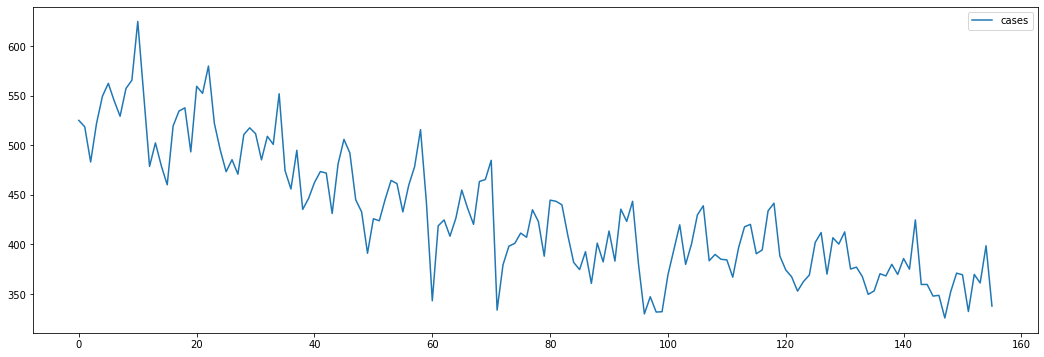

In [3]:
accidents.plot(figsize=(18,6));

## Take care and stay healthy!!